In [16]:
import numpy             as np
import filters           as fil
import shared_functions  as sf
import scipy.io.wavfile  as wav
import matplotlib.pyplot as plt
import librosa           as lib

audio_fn = 'input/4x_lil_deb.wav'
fs, source_audio = wav.read(audio_fn)


/home/andrew/.local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [14]:
def place_audio(grain, start_index, target_audio):
    #add grain sample-wise to target_audio starting at start_index
    if (start_index + len(grain)) <= len(target_audio[0]):
        left, right = random_panning(grain)
        left        = lowpass_open_with_higher_prob(grain, prob)
        target_audio[0][start_index:start_index+len(grain)] += left
        target_audio[1][start_index:start_index+len(grain)] += right

    else:
        print('problem with placement indices: ')
        print('start_index: ' + str(start_index))
        print('len(grain): ' + str(len(grain)))
        print('len(target_audio): ' + str(len(target_audio)))
        
    return target_audio

def place_audio_two_channels(grain_l, grain_r, start_index, target_audio):
    #add grain sample-wise to target_audio starting at start_index
    if (start_index + len(grain_l)) <= len(target_audio[0]):
        target_audio[0][start_index:start_index+len(grain_l)] += grain_l
        target_audio[1][start_index:start_index+len(grain_r)] += grain_r

    # else:
    #     print('problem with placement indices: ')
    #     print('start_index: ' + str(start_index))
    #     print('len(grain): ' + str(len(grain)))
    #     print('len(target_audio): ' + str(len(target_audio)))
        
    return target_audio

def pitch_shift_some(grain, prob, fs=44100, vals=[12.0, 24.0]):
    if np.random.random() <= prob:
        up = np.random.random() >= 0.5
        value = vals[np.random.randint(len(vals))]
        if up:
            return lib.effects.pitch_shift(grain, fs,      value)
        else:
            return lib.effects.pitch_shift(grain, fs, -1.0*value)
    else: 
        return grain

def stretch_when_prob_is_low(grain, prob):
    return lib.effects.time_stretch(grain, fil.scale(prob, 0., 1., 0.1875, 1.0 ))

def stretch_when_prob_is_high(grain, prob):
    return lib.effects.time_stretch(grain, fil.scale(prob, 1., 0., 0.1875, 1.0))

def random_panning(grain):
    pan_value = np.random.random()
    left      = grain * (-1.0 * pan_value)
    right     = grain *  (1.0 - pan_value)
    return left, right

def apply_random_filter(grain, min_cutoff=500.0, max_cutoff=1500.0):
    cutoff = (np.random.random() * (max_cutoff - min_cutoff)) + min_cutoff
    print('cutoff: ' + str(cutoff))
    if (np.random.random() >= 0.5):
        return fil.butter_lowpass_filter(grain, cutoff)
    else: 
        return fil.butter_highpass_filter(grain, cutoff)

def lowpass_open_with_higher_prob(grain, prob):
    cutoff = fil.scale(prob, 0., 1., 500.0, 1500.0)
    return fil.butter_lowpass_filter(grain, cutoff)

def highpass_open_with_higher_prob(grain, prob):
    cutoff = fil.scale((1.0 - prob), 0., 1., 500.0, 1500.0)
    return fil.butter_highpass_filter(grain, cutoff)

def should_make_grain(prob):
    #use probability to decide whether or not to make a grain
    return np.random.random() < prob

def choose_range(prob, center_index):
    #lower prob, wider range, 
    # so that the audio appears more clear at higher probs and more abstract at lower ones. 
    width = fil.scale((1.0 - prob), 0., 1., fs, fs*2)
    min_index = (max(0, center_index - width))
    max_index =         center_index + width
    return min_index, width*2

def choose_length(prob, min_len=1024, max_len=8192*2):
    #higher probability, longer grain
    return int(fil.scale(prob, 0., 1., min_len, max_len))

def choose_length_inverted(prob, min_len=1024, max_len=8192*2):
    #higher probability, shorter grain
    return int(fil.scale(prob, 1., 0., min_len, max_len))

def choose_placement(center_index, prob):
    #get window to choose from
    range_start, width = choose_range(prob, center_index)

    #choose random index in the window, then shift it over to the appropriate range.
    #return the staring index of the chunk
    return int((np.random.random()* width) + range_start)

def get_grain(start_index, grain_len, source_audio):
    if int(start_index) + grain_len <= len(source_audio):
        return source_audio[int(start_index):int(start_index)+grain_len]
    else:
        return source_audio[-(grain_len):]

def old_apply_envelope(grain):
    data     = np.copy(grain)
    ramp_len = max(10, len(grain)//10)
    ramp     = np.linspace(0., 1., ramp_len)
    data[0:len(ramp)] *= ramp
    ramp     = np.flip(ramp)
    data[len(data)-len(ramp):] *= ramp
    return data

def apply_envelope(grain):
    return np.blackman(len(grain)) * grain

def apply_to_both(left, right, function, prob):
    left  = function(left, prob)
    right = function(right, prob)
    return left, right
 

In [12]:
def process_one_index(prob, center_index, souce_audio, target_audio):
    grain_len    = choose_length_inverted(prob)
    start_index  = choose_placement(center_index, prob)
    grain        = get_grain(center_index, grain_len, source_audio)
    left, right  = random_panning(grain)
    left         = lowpass_open_with_higher_prob(left, prob)
    right        = highpass_open_with_higher_prob(right, prob)
    # left, right  = apply_to_both(left, right, stretch_when_prob_is_low, prob )
    left         = stretch_when_prob_is_low(left, prob)
    right        = stretch_when_prob_is_high(right, prob)

    if np.random.random() > 0.5:
        temp  = left
        left  = right
        right = temp

    try:
        left  = pitch_shift_some(left, prob)
        right = pitch_shift_some(left, prob)    
        
    except:
        print('problem shifting some grains')
    left         = apply_envelope(left)
    right        = apply_envelope(right)

    return  place_audio_two_channels(left, right, start_index, target_audio)
    


def process(control_curve, source_audio):
    target_audio = np.zeros((2, len(source_audio)))
    target_audio = np.copy(target_audio)
    num_grains   = 0
    num_skips    = 0

    for i in range(len(control_curve)):
        if should_make_grain(control_curve[i]):
            num_grains  += 1
            prob         = control_curve[i]
            center_index = fil.scale(i, 0, len(control_curve), 0, len(source_audio))
            target_audio = process_one_index(prob, center_index, source_audio, target_audio)
        else:
            num_skips += 1
    print('num_grains: ' + str(num_grains))
    print('num_skips: ' + str(num_skips))
    return target_audio

def old_generate_control_curve(target_length):
    return 0.125 * (sf.osc([128.0]*target_length) + 1.0 )

def generate_control_curve(target_length):
    window = np.blackman(target_length//3)
    output = np.asarray([window * 0.125, window * 0.5, window])
    return np.hstack(output)

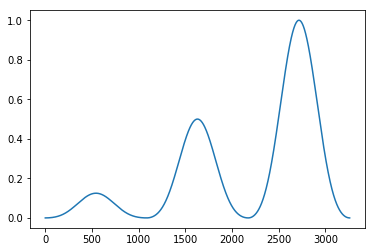

problem shifting some grains
problem shifting some grains
problem shifting some grains
problem shifting some grains
problem shifting some grains
problem shifting some grains
problem shifting some grains
problem shifting some grains
problem shifting some grains
problem shifting some grains
problem shifting some grains
problem shifting some grains
problem shifting some grains
problem shifting some grains
problem shifting some grains
problem shifting some grains
problem shifting some grains
problem shifting some grains
num_grains: 734
num_skips: 2527
saved outputs/grain_wave.wav


In [17]:
control_curve = generate_control_curve(len(source_audio)//800)
plt.plot(control_curve)
plt.show()

output = process(control_curve, source_audio)

output_fn = 'outputs/grain_wave.wav'
wav.write(output_fn, fs, output.T)
print('saved ' + output_fn)



In [ ]:
filtered = fil.butter_highpass_filter(source_audio, 1500.0)
wav.write('low.wav', fs, filtered)